This notebook uses content from [Tensorflow transfer learning tutorial](https://www.tensorflow.org/guide/keras/transfer_learning) and [Tensorflow image classification tutorial](https://www.tensorflow.org/tutorials/images/classification).

In [ ]:
!nvidia-smi

Thu Aug 17 21:10:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Image classification

This tutorial shows how to classify images of flowers. It creates an image classifier using a `tf.keras` model, and loads data using `tf.keras.utils.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Keras Functional and Sequential API.
* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [ ]:
!pip install visualkeras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 7.0 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
import visualkeras

In [ ]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 2s 0us/step


In [ ]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [ ]:
!ls /root/.keras/datasets/flower_photos/

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

In [ ]:
roses = list(data_dir.glob('roses/*'))
img = PIL.Image.open(str(roses[4]))

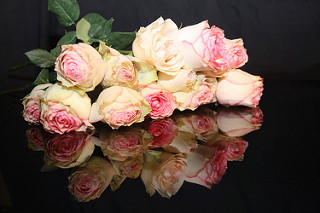

In [ ]:
img

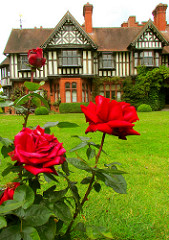

In [ ]:
PIL.Image.open(str(roses[1]))

And some tulips:

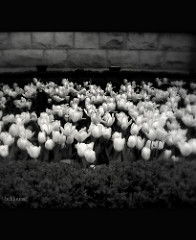

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

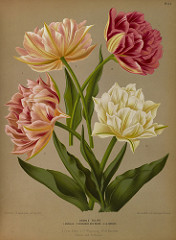

In [ ]:
PIL.Image.open(str(tulips[1]))

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

## Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

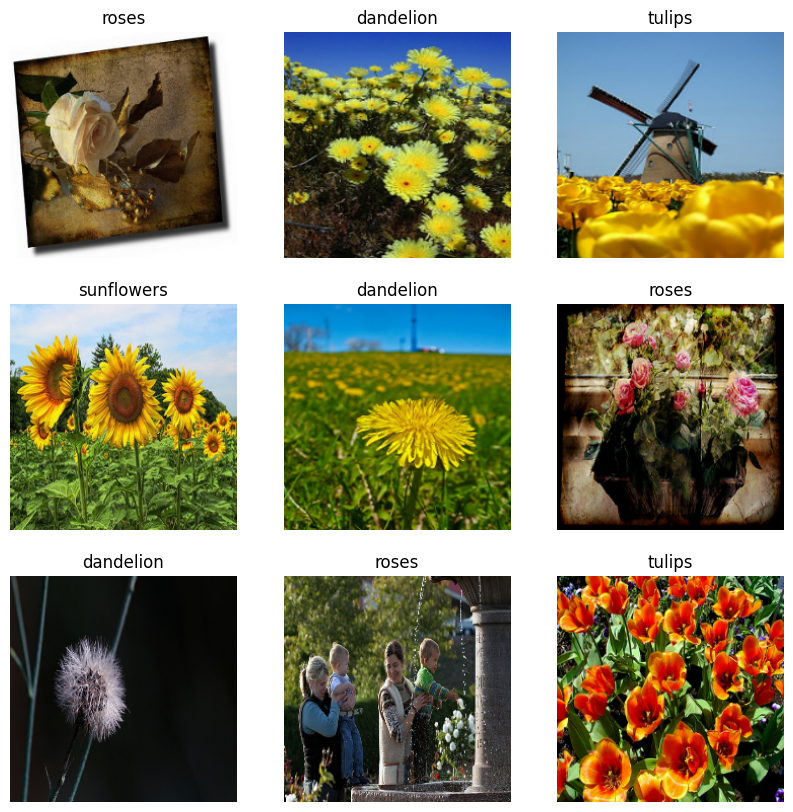

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

You will train a model using these datasets by passing them to `Model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 5)


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## The typical transfer-learning workflow

A typical transfer learning workflow can be implemented in Keras:

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting `trainable = False`.
3. Create a new model on top of the output of one (or several) layers from the base
 model.
4. Train your new model on your new dataset.


In [ ]:
# 1. Instantiate a base model with pre-trained weights.
base_model = keras.applications.resnet.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,  # we exclude the final layer
    #pooling='avg',
    )  # Do not include the ImageNet classifier at the top.

base_model.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

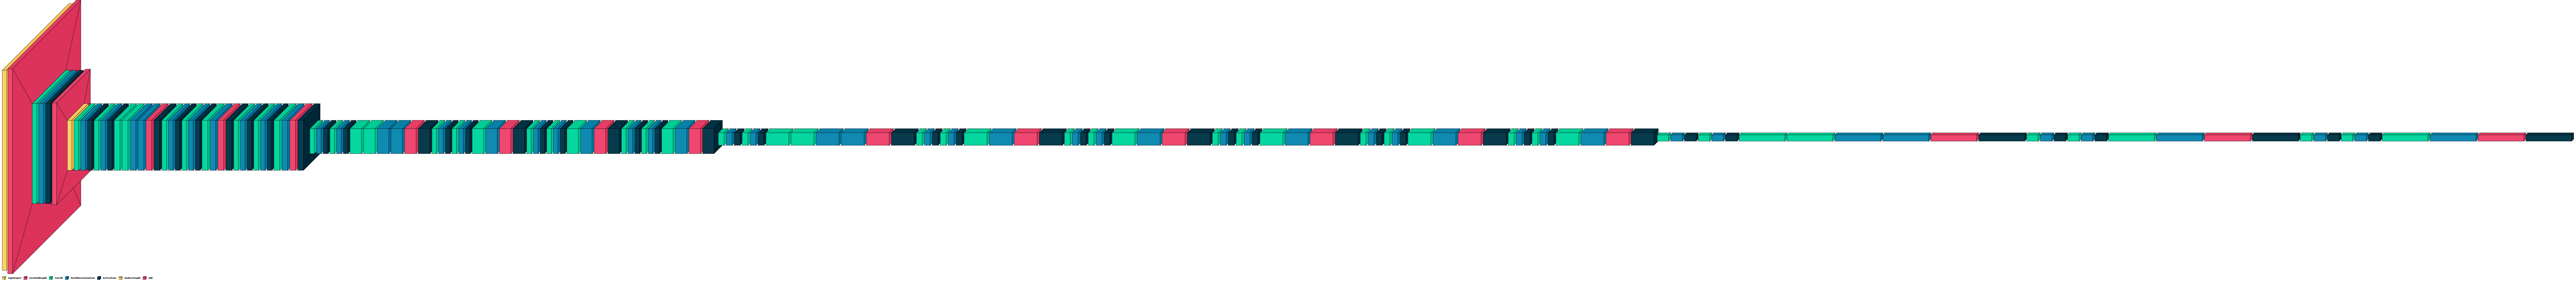

In [ ]:
visualkeras.layered_view(base_model, legend=True)


In [ ]:
# 2. Then, freeze the base model.
base_model.trainable = False

# 3. Create a new model on top.
inputs = keras.Input(shape=(img_height, img_width, 3))
# We must add the corresponding image pre-processing
x = keras.applications.resnet50.preprocess_input(inputs)

# Add the pre-trained model here
x = base_model(x, training=False)


# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a 5 output classes
outputs = keras.layers.Dense(5, activation='softmax')(x)

# Final model
model = keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 10245 

In [ ]:
# 4. Train the model on new data.
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
    ]
)


Epoch 1/20
92/92 [==============================] - 34s 157ms/step - loss: 0.5479 - accuracy: 0.8018 - val_loss: 0.3546 - val_accuracy: 0.8856
Epoch 2/20
92/92 [==============================] - 12s 126ms/step - loss: 0.2573 - accuracy: 0.9104 - val_loss: 0.2778 - val_accuracy: 0.8978
Epoch 3/20
92/92 [==============================] - 11s 122ms/step - loss: 0.1868 - accuracy: 0.9414 - val_loss: 0.2836 - val_accuracy: 0.9033
Epoch 4/20
92/92 [==============================] - 11s 122ms/step - loss: 0.1452 - accuracy: 0.9595 - val_loss: 0.2490 - val_accuracy: 0.9114
Epoch 5/20
92/92 [==============================] - 11s 121ms/step - loss: 0.1181 - accuracy: 0.9680 - val_loss: 0.2421 - val_accuracy: 0.9196
Epoch 6/20
92/92 [==============================] - 11s 120ms/step - loss: 0.0970 - accuracy: 0.9772 - val_loss: 0.2360 - val_accuracy: 0.9183
Epoch 7/20
92/92 [==============================] - 11s 119ms/step - loss: 0.0792 - accuracy: 0.9826 - val_loss: 0.2457 - val_accuracy: 0.9142

### Using random data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.5),
        layers.RandomZoom(0.5),
    ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

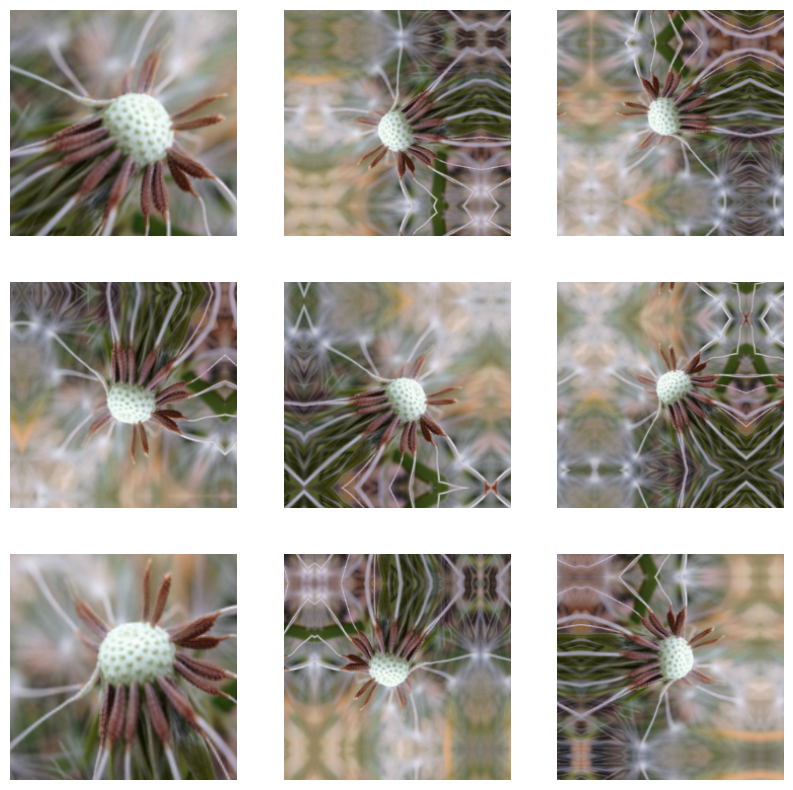

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [ ]:
# 1. Instantiate a base model with pre-trained weights.
base_model = keras.applications.resnet.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# 2. Then, freeze the base model.
base_model.trainable = False

# 3. Create a new model on top.
inputs = keras.Input(shape=(img_height, img_width, 3))

# Apply Data augmentation on input images
x = data_augmentation(inputs)

# We must add the corresponding image pre-processing
x = keras.applications.resnet50.preprocess_input(x)

# Add the pre-trained model here
x = base_model(x, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# Add dropout
x = layers.Dropout(0.5)(x)

# A Dense classifier with a 5 output classes
outputs = keras.layers.Dense(5, kernel_regularizer='l2', activation='softmax')(x)

# Final model
model = keras.Model(inputs, outputs)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [ ]:
# 4. Train the model on new data.
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
    ]
)


Epoch 1/20
92/92 [==============================] - 17s 144ms/step - loss: 1.1257 - accuracy: 0.6216 - val_loss: 0.5219 - val_accuracy: 0.8665
Epoch 2/20
92/92 [==============================] - 12s 132ms/step - loss: 0.6841 - accuracy: 0.7830 - val_loss: 0.4757 - val_accuracy: 0.8583
Epoch 3/20
92/92 [==============================] - 12s 133ms/step - loss: 0.6041 - accuracy: 0.8174 - val_loss: 0.3980 - val_accuracy: 0.8856
Epoch 4/20
92/92 [==============================] - 12s 132ms/step - loss: 0.5687 - accuracy: 0.8266 - val_loss: 0.3802 - val_accuracy: 0.8992
Epoch 5/20
92/92 [==============================] - 12s 130ms/step - loss: 0.5449 - accuracy: 0.8338 - val_loss: 0.3856 - val_accuracy: 0.8869
Epoch 6/20
92/92 [==============================] - 12s 132ms/step - loss: 0.5010 - accuracy: 0.8420 - val_loss: 0.3633 - val_accuracy: 0.9046
Epoch 7/20
92/92 [==============================] - 12s 131ms/step - loss: 0.4858 - accuracy: 0.8532 - val_loss: 0.3464 - val_accuracy: 0.9087

## Do a round of fine-tuning of the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.


In [ ]:
# Unfreeze the base_model
base_model.trainable = True
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [ ]:
# Train the entire model, use a low learning rate
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer_model = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
    ]
)


Epoch 1/20
92/92 [==============================] - 78s 393ms/step - loss: 0.4413 - accuracy: 0.8692 - val_loss: 0.3020 - val_accuracy: 0.9142
Epoch 2/20
92/92 [==============================] - 33s 360ms/step - loss: 0.3614 - accuracy: 0.9057 - val_loss: 0.2845 - val_accuracy: 0.9183
Epoch 3/20
92/92 [==============================] - 33s 357ms/step - loss: 0.3216 - accuracy: 0.9108 - val_loss: 0.2881 - val_accuracy: 0.9196
Epoch 4/20
92/92 [==============================] - 33s 359ms/step - loss: 0.2907 - accuracy: 0.9213 - val_loss: 0.2879 - val_accuracy: 0.9169
Epoch 5/20
92/92 [==============================] - 33s 360ms/step - loss: 0.2539 - accuracy: 0.9353 - val_loss: 0.2525 - val_accuracy: 0.9332
Epoch 6/20
92/92 [==============================] - 33s 359ms/step - loss: 0.2437 - accuracy: 0.9387 - val_loss: 0.2452 - val_accuracy: 0.9373
Epoch 7/20
92/92 [==============================] - 33s 357ms/step - loss: 0.2312 - accuracy: 0.9441 - val_loss: 0.2764 - val_accuracy: 0.9251

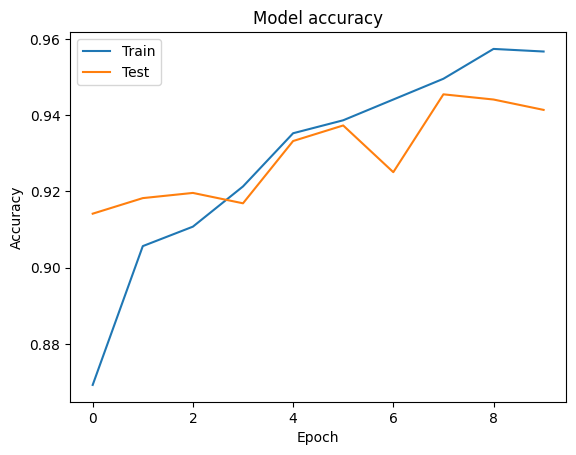

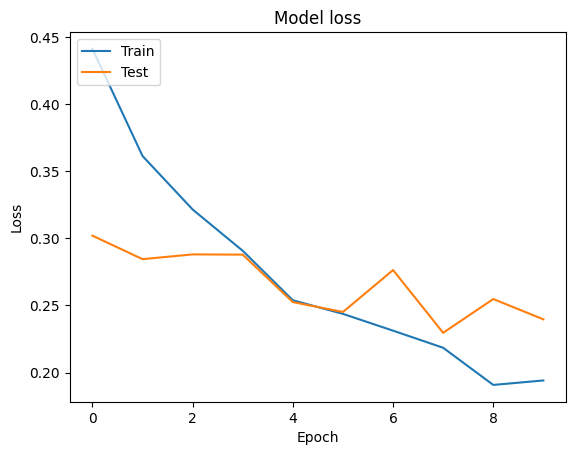

In [ ]:
plot_history(history_transfer_model)

## Versus fine-tuning the entire model from the beginning

In [ ]:
# 1. Instantiate a base model with pre-trained weights.
base_model = keras.applications.resnet.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# 2. Then, freeze the base model.
base_model.trainable = True

# 3. Create a new model on top.
inputs = keras.Input(shape=(img_height, img_width, 3))

# Apply Data augmentation on input images
x = data_augmentation(inputs)

# We must add the corresponding image pre-processing
x = keras.applications.resnet50.preprocess_input(x)

# Add the pre-trained model here
x = base_model(x, training=True)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# Add dropout
x = layers.Dropout(0.5)(x)

# A Dense classifier with a 5 output classes
outputs = keras.layers.Dense(5, activation='softmax')(x)

# Final model
model = keras.Model(inputs, outputs)

model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

In [ ]:
# Train the entire model, use a low learning rate
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_model = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
    ]
)


Epoch 1/20
92/92 [==============================] - 76s 374ms/step - loss: 0.6285 - accuracy: 0.7667 - val_loss: 0.3030 - val_accuracy: 0.9114
Epoch 2/20
92/92 [==============================] - 33s 362ms/step - loss: 0.3127 - accuracy: 0.8910 - val_loss: 0.2444 - val_accuracy: 0.9128
Epoch 3/20
92/92 [==============================] - 33s 356ms/step - loss: 0.2361 - accuracy: 0.9189 - val_loss: 0.2824 - val_accuracy: 0.9155
Epoch 4/20
92/92 [==============================] - 33s 357ms/step - loss: 0.1674 - accuracy: 0.9366 - val_loss: 0.2509 - val_accuracy: 0.9210
Epoch 5/20
92/92 [==============================] - 33s 356ms/step - loss: 0.1761 - accuracy: 0.9360 - val_loss: 0.2665 - val_accuracy: 0.9332
Epoch 6/20
92/92 [==============================] - 33s 356ms/step - loss: 0.1326 - accuracy: 0.9527 - val_loss: 0.2254 - val_accuracy: 0.9319
Epoch 7/20
92/92 [==============================] - 33s 357ms/step - loss: 0.1065 - accuracy: 0.9622 - val_loss: 0.2158 - val_accuracy: 0.9360

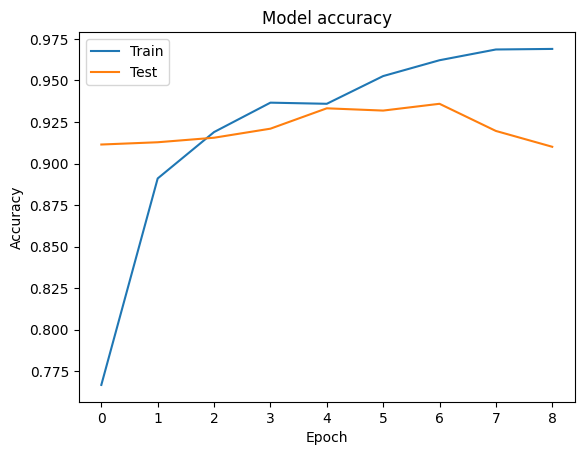

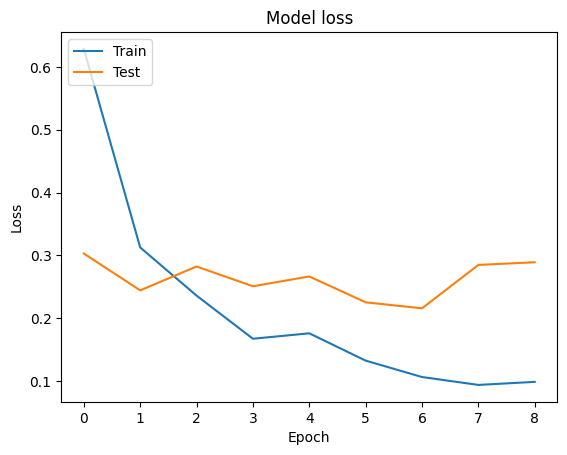

In [ ]:
plot_history(history_model)